In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator
import datetime
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from torchfm.model.ffm import FieldAwareFactorizationMachineModel
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import log_loss, roc_auc_score



In [1]:
%pip install torchfm

  Preparing metadata (setup.py) ... done
  Created wheel for torchfm: filename=torchfm-0.7.0-py3-none-any.whl size=18337 sha256=98536a0b4aef0aeed8ef428a1e2f6aac155e6a2c35e16b5db7eb83912c1cba0c
  Stored in directory: /root/.cache/pip/wheels/8c/43/dc/9d217203896e5776b57c5d392b8baadfe0139647c8af31f39d
Successfully built torchfm
Note: you may need to restart the kernel to use updated packages.


In [4]:
data = pd.read_csv('/kaggle/input/ad-clicks/data.csv')
data.head()

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,banner_id0,rate0,g0,coeff_sum0,banner_id1,rate1,g1,coeff_sum1,impressions,clicks
0,2021-09-27 00:01:30.000000,0,0,5664530014561852622,0,0,0,1240,0.067,0.035016,-7.268846,0,0.010,0.049516,-5.369901,1,1
1,2021-09-26 22:54:49.000000,1,1,5186611064559013950,0,0,1,1,0.002,0.054298,-2.657477,269,0.004,0.031942,-4.449220,1,1
2,2021-09-26 23:57:20.000000,2,2,2215519569292448030,3,0,0,2,0.014,0.014096,-3.824875,21,0.014,0.014906,-3.939309,1,1
3,2021-09-27 00:04:30.000000,3,3,6262169206735077204,0,1,1,3,0.012,0.015232,-3.461357,99,0.006,0.050671,-3.418403,1,1
4,2021-09-27 00:06:21.000000,4,4,4778985830203613115,0,1,0,4,0.019,0.051265,-4.009026,11464230,6.790,0.032005,-2.828797,1,1


In [5]:
data.drop(['banner_id0', 'banner_id1', 'rate0', 'rate1', 'g0', 'g1', 'coeff_sum0', 'coeff_sum1' ], axis=1, inplace=True)

## Рабочие фичи
* date_time - время показа рекламы
* oaid_hash - хэш юзера
* zone_id - id зоны, где зона - место на сайте для размещения рекламы
* banner_id - id баннера, где баннер - сама реклама
* campaign_clicks - общее количество показов данной кампании (которой соотвествует баннер) данному юзеру, произошедшие до текущего показа. Кампанию стоит понимать * как что-то общее (рекламодатель/тематика/ и т. п.) для баннеров.
* os_id - id операционной системы
* country_id - id страны
* impressions - был ли показ
* clicks - был ли клик

Как и в прошлом дз поделим дату и время на дату и время суток и день недели.

In [6]:
data['date_time'] = pd.to_datetime(data['date_time'], errors='coerce')
data['date'] = pd.to_datetime(data['date_time']).dt.date
data['day_of_the_week'] = data['date_time'].dt.day_of_week
data['day_period'] = (data['date_time'].dt.hour % 24 + 4) // 4
data.drop(['date_time' ], axis=1, inplace=True)

Посмотрим на количество уникальных значений по каждой фиче.

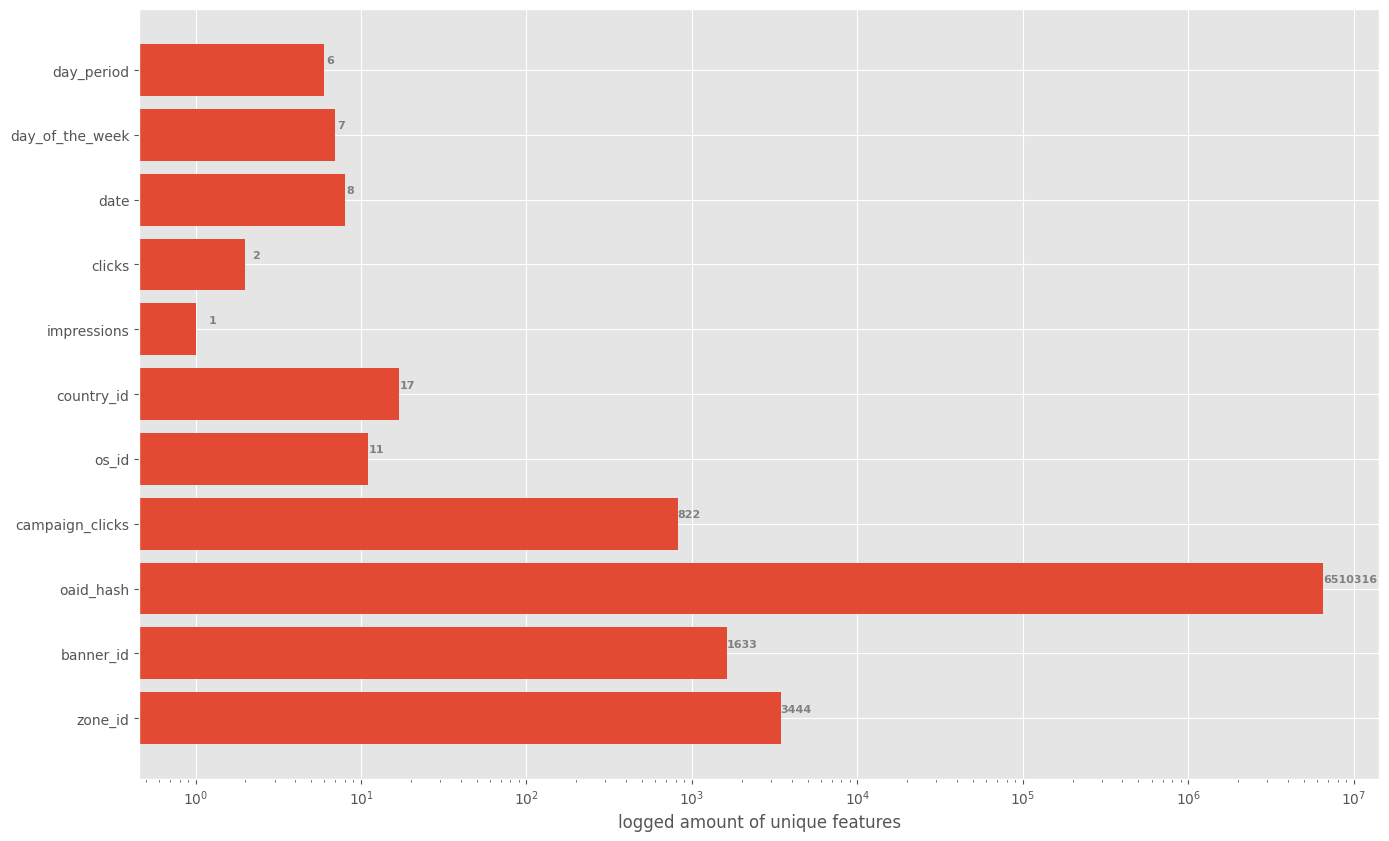

In [8]:
fig, ax = plt.subplots()
features = []
y = []
for feature in data:
  features.append(feature)
  y.append(len(data[feature].unique()))

plt.rcParams['figure.figsize'] = (16.0, 10.0)
plt.style.use('ggplot')
p = plt.barh(features,y)

for c,i in enumerate(ax.patches):
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
            y[c],
             fontsize=8, fontweight='bold',
             color='grey')
plt.xscale('log')
plt.xlabel('logged amount of unique features')
plt.show()

  

Нам интресно посмотреть как распределены country_id,os_id,date,day_period.

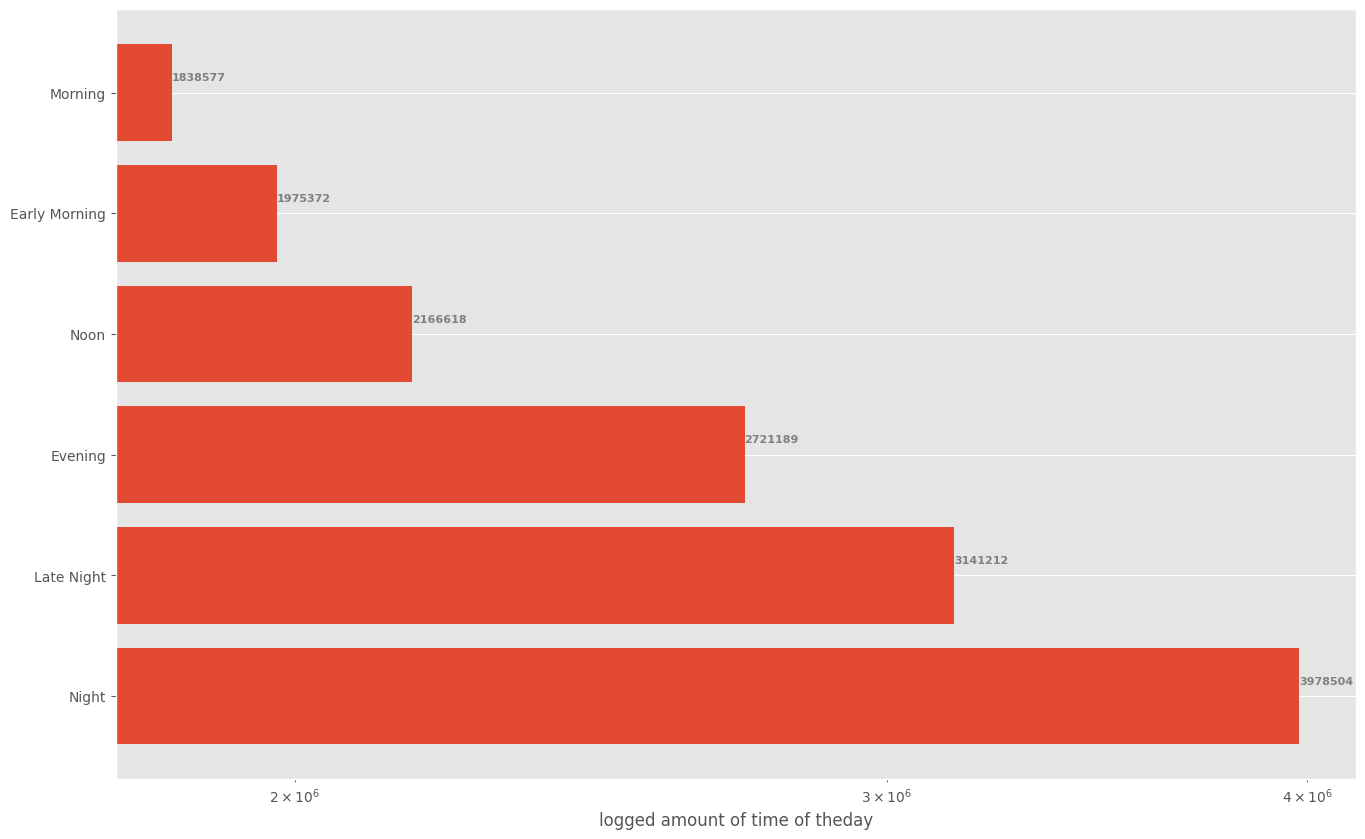

In [9]:
fig, ax = plt.subplots()
d = dict(data['day_period'].value_counts())
values= list(d.keys())
time_periods = {1: 'Early Morning', 2: 'Morning', 3: 'Noon', 4: 'Evening', 5: 'Night', 6: 'Late Night'}

for i in range(len(values)):
    if values[i] in time_periods.keys():
        values[i] = time_periods[values[i]]

y = list(d.values())


plt.rcParams['figure.figsize'] = (16.0, 10.0)
plt.style.use('ggplot')
p = plt.barh(values,y)

for c,i in enumerate(ax.patches):
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
            y[c],
             fontsize=8, fontweight='bold',
             color='grey')
plt.xscale('log')
plt.xlabel('logged amount of time of theday')
plt.show()


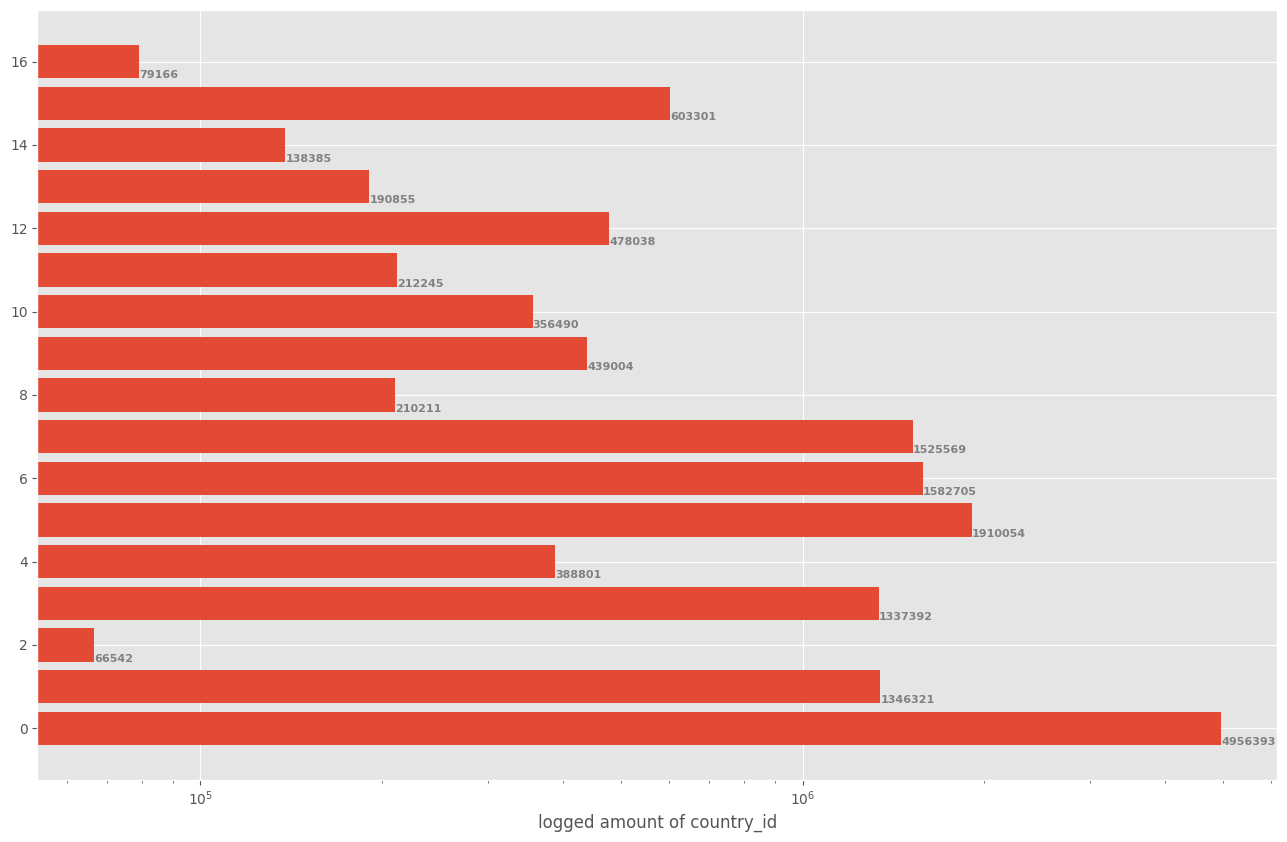

In [10]:
fig, ax = plt.subplots()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
d = dict(data['country_id'].value_counts())
country= list(d.keys())

y = list(d.values())

plt.rcParams['figure.figsize'] = (16.0, 10.0)
# plt.style.use('ggplot')
p = plt.barh(country,y)

for c,i in enumerate(ax.patches):
    plt.text(i.get_width(), i.get_y(),
            y[c],
             fontsize=8, fontweight='bold',
             color='grey')
plt.xscale('log')
plt.xlabel('logged amount of country_id')
plt.show()

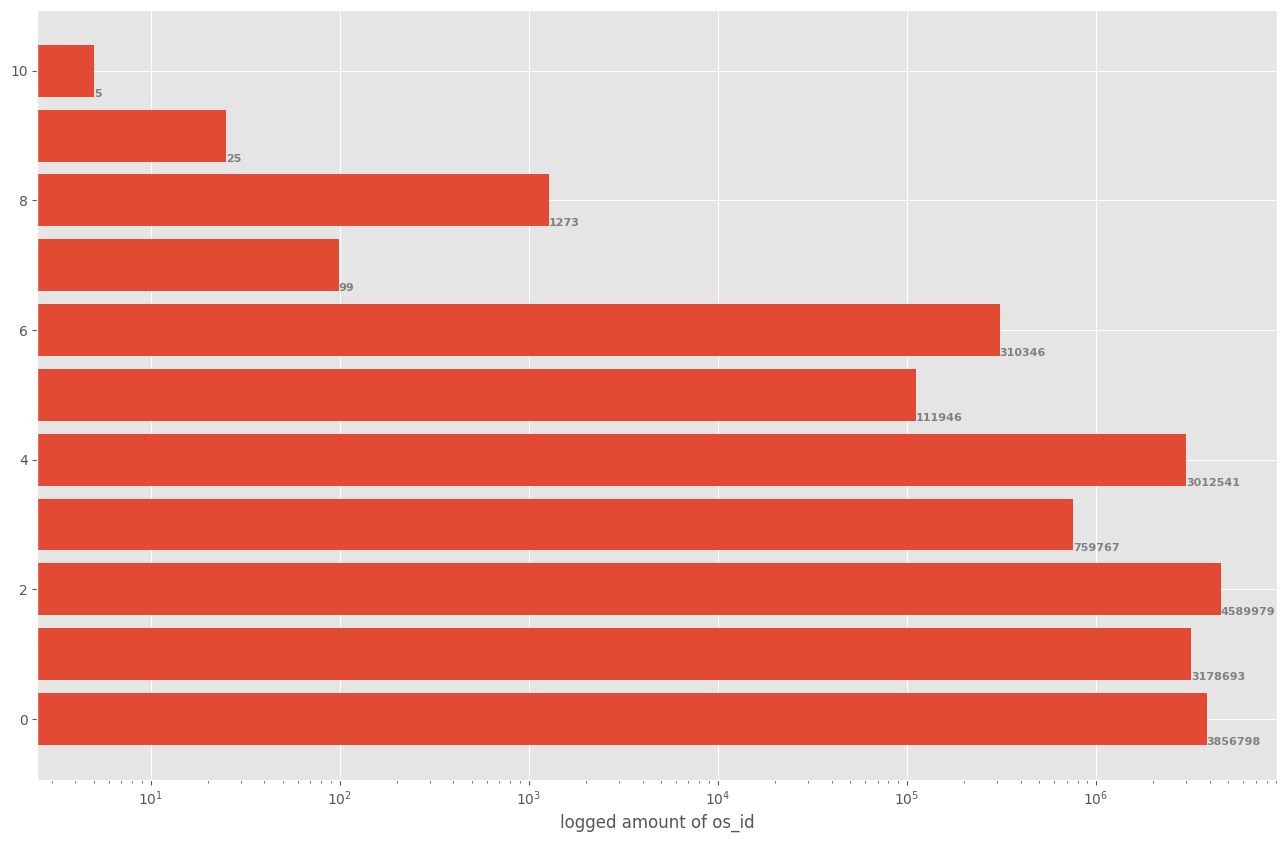

In [11]:
fig, ax = plt.subplots()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
d = dict(data['os_id'].value_counts())
country= list(d.keys())
y = list(d.values())
plt.rcParams['figure.figsize'] = (16.0, 10.0)
plt.style.use('ggplot')
p = plt.barh(country,y)

for c,i in enumerate(ax.patches):
    plt.text(i.get_width(), i.get_y(),
            y[c],
             fontsize=8, fontweight='bold',
             color='grey')
plt.xscale('log')
plt.xlabel('logged amount of os_id')
plt.show()

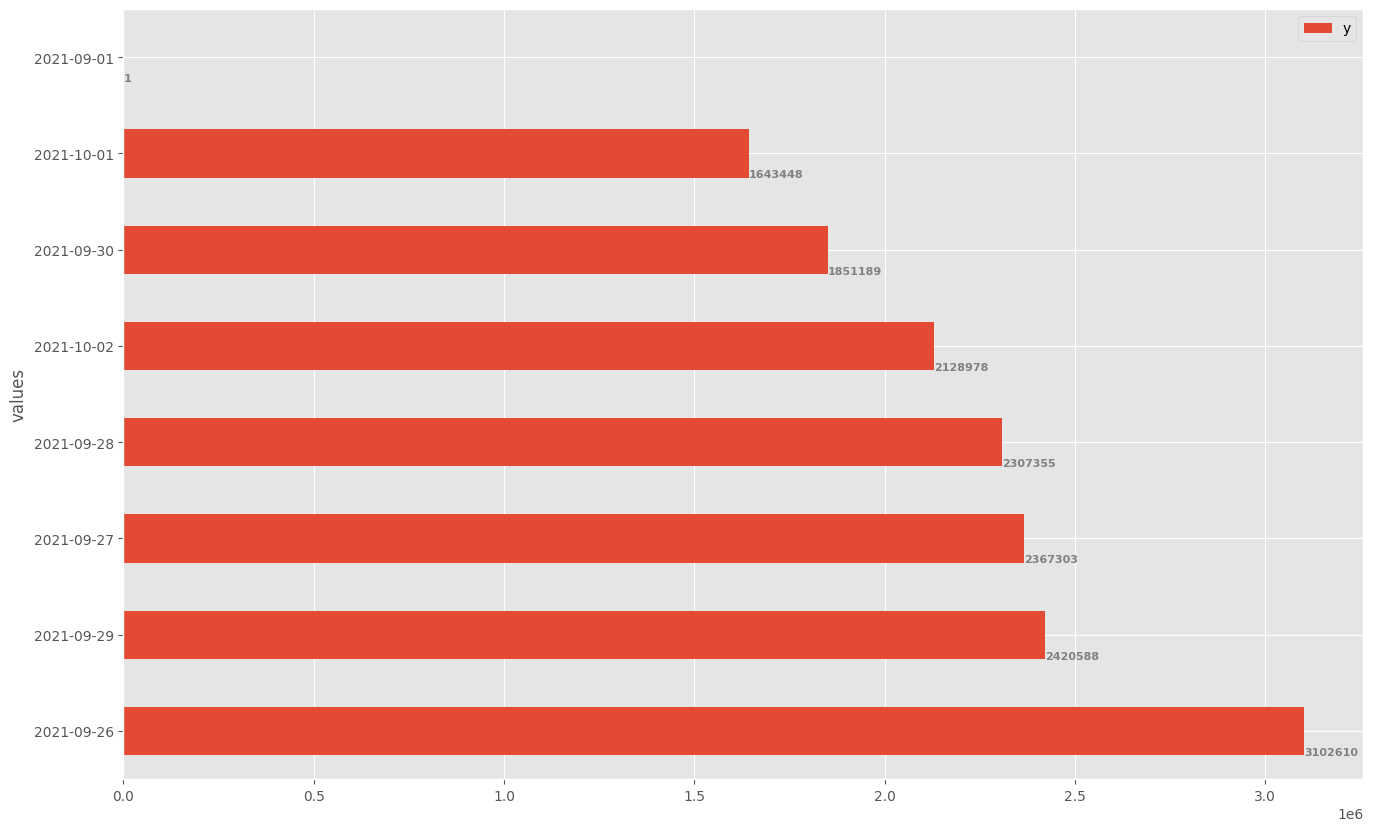

In [12]:
d = dict(data['date'].value_counts())
values= list(d.keys())
y = list(d.values())
df = pd.DataFrame({'values': values, 'y': y})
ax = df.plot.barh(x='values', y='y')
for c,i in enumerate(ax.patches):
    plt.text(i.get_width(), i.get_y(),
            y[c],
             fontsize=8, fontweight='bold',
             color='grey')

In [13]:
print(f"Date which needs to be in test: {max(d.keys())}")

Date which needs to be in test: 2021-10-02


Можно сказать, что количество некоторых операционных систем под номерами достаточно мало , хотелось бы еще посмотреть сколько кликов было у этих операционных систем.

In [14]:
for id in range(11):
    counter = len(data[(data['clicks'] == 1) & (data['os_id'] == id)])
    print(f"id: {id}, clicks: {counter}")

id: 0, clicks: 115943
id: 1, clicks: 42971
id: 2, clicks: 81848
id: 3, clicks: 36502
id: 4, clicks: 119245
id: 5, clicks: 5967
id: 6, clicks: 19739
id: 7, clicks: 3
id: 8, clicks: 31
id: 9, clicks: 0
id: 10, clicks: 0


Кликов при использовании этих ос очень мало. А объект с датой 2021-09-01 можно вообще убрать, так как это можно расценивать как выброс.

In [15]:
data = data[data['date'] != datetime.date(2021, 9, 1)]

In [16]:
data['date'].unique()

array([datetime.date(2021, 9, 27), datetime.date(2021, 9, 26),
       datetime.date(2021, 9, 29), datetime.date(2021, 9, 30),
       datetime.date(2021, 9, 28), datetime.date(2021, 10, 1),
       datetime.date(2021, 10, 2)], dtype=object)

Также нам известно какие значения фичей редко встречаются и мы можем попробывать объединить их в одну по filtering_fraction.

In [17]:
def combine_val(data: pd.DataFrame, filtering_fraction: float = 0.05, relabel: int = 100000000000) -> pd.DataFrame:
    size = len(data)
    threshold = size * filtering_fraction
    
    fields_to_combine = ["zone_id", "banner_id", "os_id", "country_id", "oaid_hash", "day_of_the_week", "day_period"]

    for field in fields_to_combine:
        if field in ['banner_id', 'oaid_hash']:
            continue
        
        counts = data[field].value_counts()
        rare_values = counts[counts < threshold].index.tolist()
        
        data[field] = np.where(data[field].isin(rare_values), relabel, data[field])
    
    for field in fields_to_combine:
        data[field] = data.groupby(field).ngroup()
    
    return data

In [18]:
new_data = combine_val(data)

In [61]:
field_dims = [np.max(new_data[columnName]) + 1 for columnName in new_data.columns if columnName != 'date' and columnName !="clicks" and columnName !="date"]

In [60]:
print(new_data.columns)

Index(['zone_id', 'banner_id', 'oaid_hash', 'campaign_clicks', 'os_id',
       'country_id', 'impressions', 'clicks', 'date', 'day_of_the_week',
       'day_period'],
      dtype='object')


In [62]:
print(len(field_dims))

9


Разделим выборку на трейн и тест

In [22]:
X_test = new_data[new_data['date'] == datetime.date(2021, 10, 2)]
X_train = new_data[new_data['date'] != datetime.date(2021, 10, 2)]

In [23]:
print(f"X_test: {len(X_test.index)} X_train: {len(X_train.index)} Total: {len(X_test.index)+len(X_train.index)}")

X_test: 2128978 X_train: 13692493 Total: 15821471


По комментарием из первого ДЗ будем делать валидацию по дате и возьмем последний день в тест а пред последний в валидацию.

In [ ]:
X_val = X_train[X_train['date'] == datetime.date(2021, 9, 30)]
X_train = X_train[X_train['date'] != datetime.date(2021, 9, 30)]

Подготовка к FFM

In [40]:
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        label = float(row['clicks'])
        features = row.drop(['clicks']).to_numpy()
        return features, label

In [41]:
X_t = X_train.drop('date', axis=1, inplace=False)
X_v = X_val.drop('date', axis=1, inplace=False)

In [ ]:
X_tt = X_train.drop('date', axis=1, inplace=False)

In [75]:
X_te = X_test.drop('date', axis=1, inplace=False)

In [42]:
train_dataset = MyDataset(X_t)
val_dataset = MyDataset(X_v)

In [80]:
loader_t = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=2)
loader_v = DataLoader(val_dataset, batch_size=1024, shuffle=False, num_workers=2)

In [63]:
np.long = np.float64
model = FieldAwareFactorizationMachineModel(field_dims, 5).cuda()
optim = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.001)
criterion = torch.nn.BCELoss()

In [ ]:
n_epochs = 1

for e in range(n_epochs):
    pbar = tqdm(enumerate(loader_t))
    for i, (features, labels) in pbar:
#             print(features.shape)
#             print(labels.shape)
            features = torch.LongTensor(features).to('cuda')
            labels = labels.float().to('cuda')
#             print(features.shape)
#             print(labels.shape)
            pred = model(features)
            loss = criterion(pred, labels)
            loss.backward()
            optim.step()
            optim.zero_grad()
            pbar.set_description(f"Training loss {i}: {loss.cpu().detach().item()}")

0it [00:00, ?it/s]

In [73]:
y_true = []
y_pred = []

for features, clicks in tqdm(loader_v):
    features = torch.LongTensor(features).to('cuda')
    y_true.extend(clicks.tolist())
    y_pred.extend(model(features).detach().cpu().tolist())

  0%|          | 0/1808 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bb7c6244f70>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bb7c6244f70>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/op

In [74]:
print("Log loss", log_loss(y_true, y_pred))
print("ROC AUC", roc_auc_score(y_true, y_pred))

Log loss 0.1339536683178282
ROC AUC 0.9887851842323155


In [76]:
test_dataset = MyDataset(X_te)
loader_test = DataLoader(test_dataset, batch_size=1024, shuffle=False, num_workers=2)


In [78]:
y_true_test = []
y_pred_test = []

for features, clicks in tqdm(loader_test):
    features = torch.LongTensor(features).to('cuda')
    y_true_test.extend(clicks.tolist())
    y_pred_test.extend(model(features).detach().cpu().tolist())

  0%|          | 0/2080 [00:00<?, ?it/s]

In [79]:
print("Log loss", log_loss(y_true_test, y_pred_test))
print("ROC AUC", roc_auc_score(y_true_test, y_pred_test))

Log loss 0.19068501003603255
ROC AUC 0.6487738689966914
